In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 219107776'

In [4]:
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=5)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   219107776      0.0
  1 TESS Sector 15 2019   SPOC     120   219107776      0.0
  2 TESS Sector 16 2019   SPOC     120   219107776      0.0
  3 TESS Sector 17 2019   SPOC     120   219107776      0.0
  4 TESS Sector 18 2019   SPOC     120   219107776      0.0


[9244]
[7252]
[7170]
[6275]
[ 323 6839]


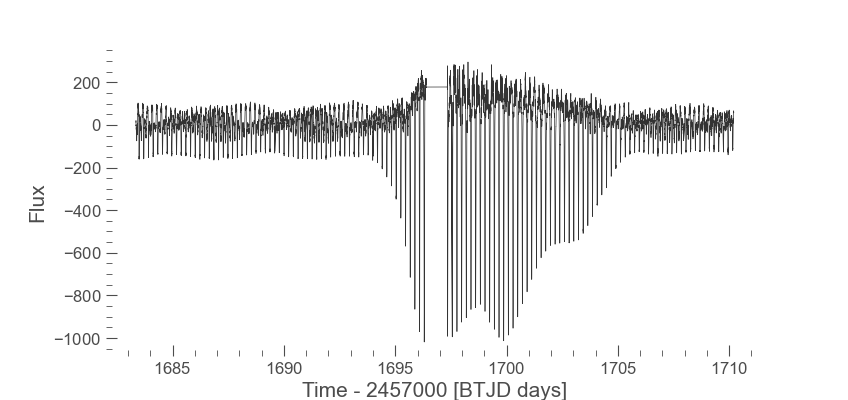

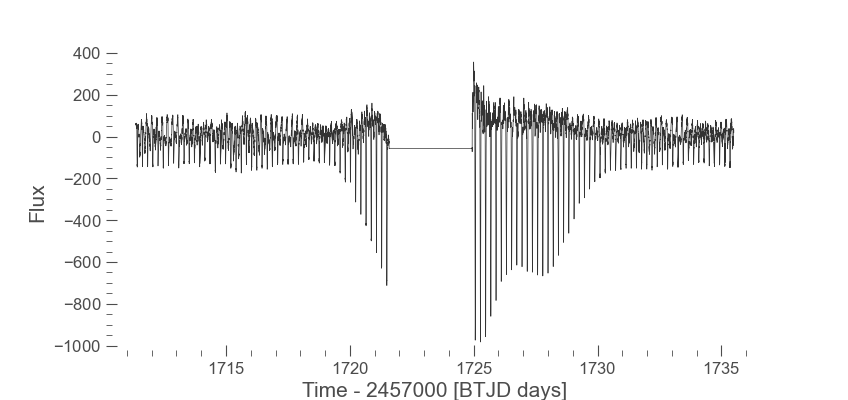

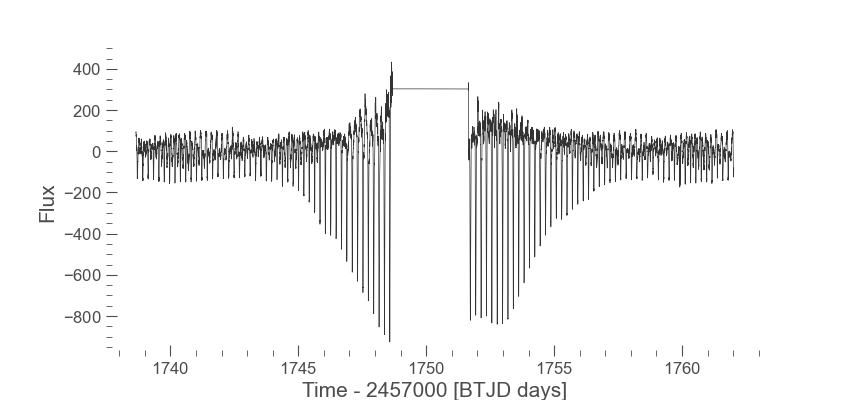

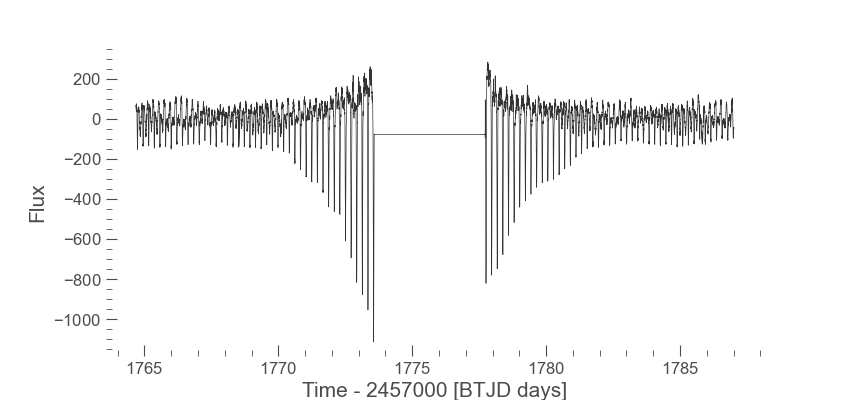

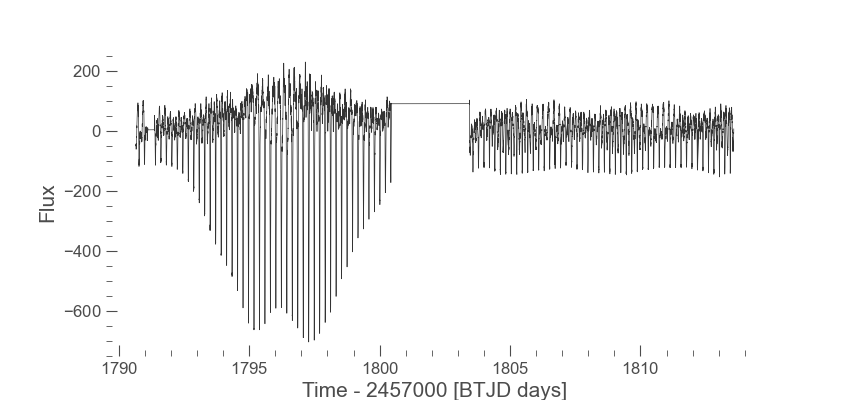

In [6]:
new_lcs = []

for lc in lcs:
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=1500)
    new_lc = straight_lines(new_lc, cadence_magnifier= 20)
    new_lcs.append(new_lc)
    new_lc.plot()

In [ ]:
lightcurve = combine_lightcurves(new_lcs)

In [ ]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 50)
periodogram.plot()

In [ ]:
lightcurve.plot()

In [ ]:
periodogram.plot()

In [ ]:
frequencies = periodogram.frequency.value
power = periodogram.power.value

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

pd.DataFrame({'frequencies': frequencies, 'power': power})

peaks, pdict = signal.find_peaks(power, height=60)

print(peaks[0])

print(frequencies[peaks][0])

print(pdict['peak_heights'][0])

1/(lightcurve.time.btjd[-1] - lightcurve.time.btjd[0])

initial_guess = [pdict['peak_heights'][0], frequencies[peaks][0], 0.5/(lightcurve.time.btjd[-1] - lightcurve.time.btjd[0])]

optimized_parameters, covariance = optimize.curve_fit(gaussian, frequencies, power, p0=initial_guess)

amp, cen, wid = optimized_parameters

f = np.linspace(frequencies.min(), frequencies.max(), 1000000)

fitted_gaussian = gaussian(f, amp, cen, wid)

another_gaussian = gaussian(f, pdict['peak_heights'][0], frequencies[peaks][0], 0.5/(lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]))

plt.figure(figsize=(10, 5))
plt.plot(frequencies, power, label='Periodogram', marker='o', markersize=1, alpha=0.5, color='black')
plt.plot(f, fitted_gaussian, label='Fitted Gaussian', color='red')
plt.plot(f, another_gaussian, label='Another Gaussian', color='blue')

print(f'Amplitude: {amp}')
print(f'Central Frequency: {cen}')
print(f'Standard Deviation: {wid}')


In [ ]:
def sin_fit(x, amp, freq, phase, offset):
    return amp * np.sin(2 * np.pi * freq * (x - phase)) + offset

t = lightcurve.time.btjd
f = lightcurve.flux

s = sin_fit(t, 100, cen, 0.0611, -100)

ax = lightcurve.plot()
ax.plot(t, s, color='red')

In [ ]:
bin_num = 200
period = 1/cen
lightcurve.fold(period).bin(time_bin_size = period/bin_num).scatter()

In [ ]:
l = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=2)
l[0].fold(period).bin(time_bin_size = 0.0005).scatter()